In [1]:
import os
import copy
import functools
from collections import defaultdict

import lmfit
import corner
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.stats import linregress
from matplotlib.ticker import MultipleLocator
from lmfit import Parameter, Parameters 

import sivqed.models.fitter as fitter
from sivqed.models.cavity import Cavity, MultiQubitCavity
from sivqed.models.fitter import cavity_ref_model, single_siv_ref_model, mcmc
from sivqed.models.diffusion import diffused_siv_peaks, plot_diffused_contrasts

np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [8, 5]

In [2]:
cavity_path = "../data/20210629_new_SiV_6338/"
siv_path = "../data/20210629_new_SiV_6338/"

cavity_files = ["b96r1_3rddetuning_raw-counts_x_18_03_30.txt", "b96r1_3rddetuning_raw-counts_18_03_30.txt"]

# List of 2-tuples, first is the avg file (which contains the freq values), second is the scans file
siv_files = [["sweeper_bwd_avg_17_35_53.txt", "sweeper_bwd_scans_17_35_53.txt"],  
             ["sweeper_fwd_avg_17_35_53.txt", "sweeper_fwd_scans_17_35_53.txt"]]

# Plot data

## Plot Cavity Data

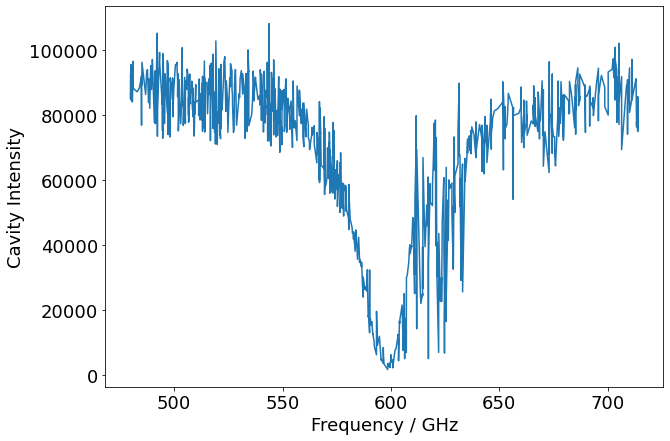

In [3]:
plt.figure(figsize=[10, 7])

cavity_freqs = np.loadtxt(cavity_path + cavity_files[0])
cavity_intensity = np.loadtxt(cavity_path + cavity_files[1])

cavity_freqs = 1000 * (cavity_freqs - 406) # Re-center, convert to GHz
plt.plot(cavity_freqs, cavity_intensity)
plt.xlabel("Frequency / GHz")
plt.ylabel("Cavity Intensity")

cavity_freqs, cavity_intensity = np.array(cavity_freqs), np.array(cavity_intensity)

## Plot SiV Data

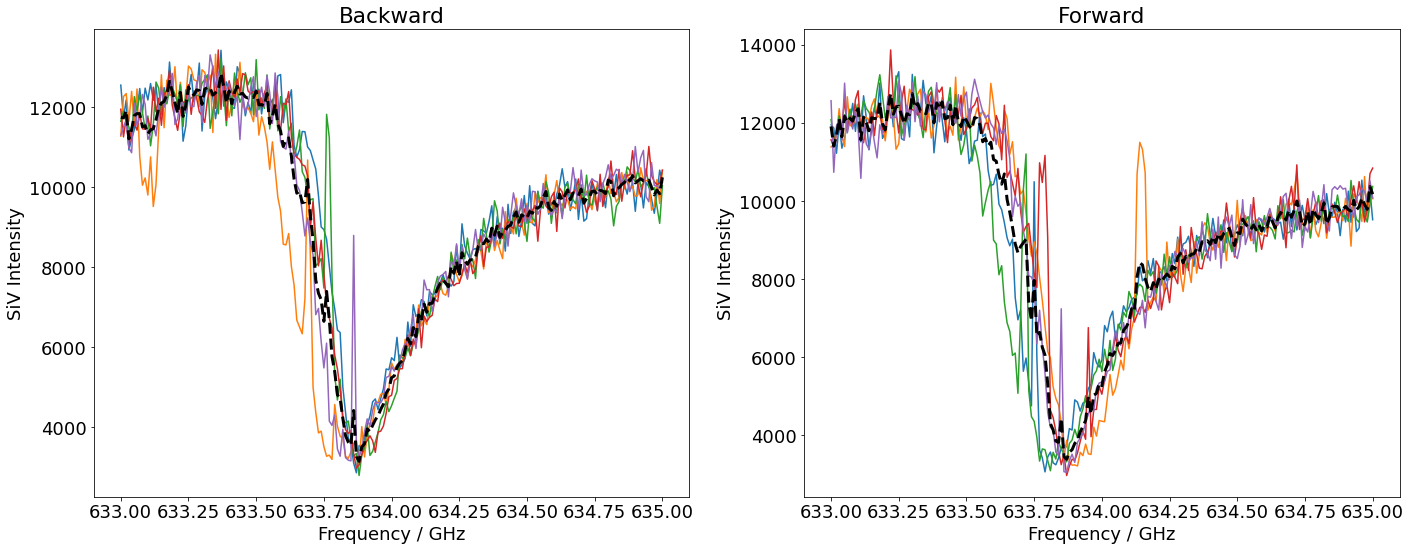

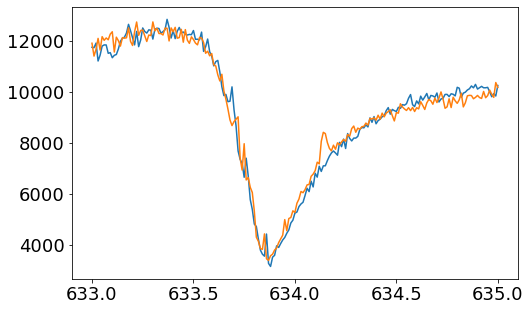

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=[20, 8])
siv_avg_scans = []

for idx, siv_files_tuple in enumerate(siv_files):
    # Extract freq from the avg scan file
    siv_freqs, _ = np.loadtxt(siv_path + siv_files_tuple[0])
    siv_freqs = 1000 * (siv_freqs - 406) # Convert to GHz

    # Extract data from the SiV scan file
    siv_data = np.loadtxt(siv_path + siv_files_tuple[1])
    
    # Chop the first 3 series which were higher power
    siv_data = siv_data[3:]
    
    for siv_series in siv_data:
        ax[idx].plot(siv_freqs, siv_series)
    
    # Plot the average scans
    siv_avg_scans.append(np.mean(siv_data, axis=0))
    ax[idx].plot(siv_freqs, np.mean(siv_data, axis=0), 'k--', lw=3)

    axes = ax[idx]
    axes.set_xlabel("Frequency / GHz")
    axes.set_ylabel("SiV Intensity")
    
    if idx == 0: 
        axes.set_title("Backward")
    else:
        axes.set_title("Forward")
        
fig.tight_layout()

plt.figure()
# Reverse the backward scan as is it backward in frequency
siv_avg_scans[0] = siv_avg_scans[0][::-1]
# Plot both together to see if any difference
plt.plot(siv_freqs, np.array(siv_avg_scans).T)

# Take the average of the front and back scans
siv_avg_data = (siv_avg_scans[0] + siv_avg_scans[1]) / 2

# --------------------
# Fit Cavity Spectrum

### Unfiltered

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 904
    # variables        = 4
    chi-square         = 8.7848e+10
    reduced chi-square = 97608491.0
    Akaike info crit   = 16634.4046
    Bayesian info crit = 16653.6319
[[Variables]]
    w_c:    600.468486 +/- 0.30385351 (0.05%) (init = 600)
    k_in:   13.6079955 +/- 0.58739324 (4.32%) (init = 30)
    k_tot:  20.6614174 +/- 0.60048134 (2.91%) (init = 50)
    A:      89832.8084 +/- 611.622671 (0.68%) (init = 100000)
    B:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, k_tot) =  0.954
    C(k_tot, A)    =  0.671
    C(k_in, A)     =  0.543


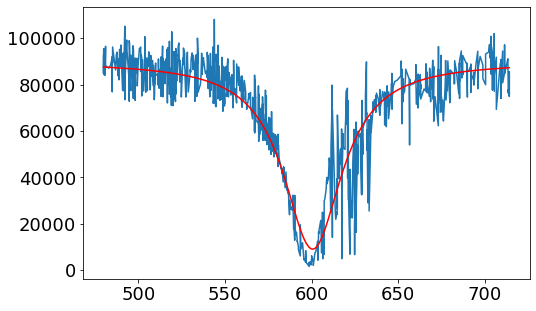

In [5]:
params = Parameters()
params.add_many(
    Parameter('w_c', value=600, min=580, max=620),
    Parameter('k_in', value=30, min=0, max=1000),
    Parameter('k_tot', value=50, min=0, max=1000),
    Parameter('A', value=100000, min=50000, max=200000),
    Parameter('B', value=0, vary=False),
)

cavity_results = cavity_ref_model.fit(cavity_intensity, params, w=cavity_freqs)
lmfit.report_fit(cavity_results)

plt.plot(cavity_freqs, cavity_intensity)
plt.plot(cavity_freqs, cavity_ref_model.eval(params=cavity_results.params, w=cavity_freqs), 'r')

fit_ratio = cavity_intensity / cavity_ref_model.eval(params=cavity_results.params, w=cavity_freqs)

### Filtered Cavity

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 155
    # data points      = 782
    # variables        = 4
    chi-square         = 3.8374e+10
    reduced chi-square = 49323419.6
    Akaike info crit   = 13856.2670
    Bayesian info crit = 13874.9144
[[Variables]]
    w_c:    598.902515 +/- 0.29502988 (0.05%) (init = 600)
    k_in:   6.69568194 +/- 0.19941755 (2.98%) (init = 6)
    k_tot:  16.8001713 +/- 0.50767798 (3.02%) (init = 50)
    A:      88229.9059 +/- 433.875499 (0.49%) (init = 100000)
    B:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_tot, A)    =  0.696
    C(w_c, k_tot)  =  0.582
    C(w_c, A)      =  0.337
    C(k_in, A)     =  0.296
    C(w_c, k_in)   =  0.226
    C(k_in, k_tot) =  0.125


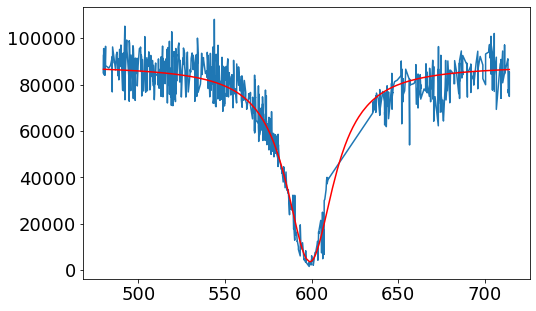

In [6]:
def not_in_range(arr, ranges):
    """ Returns indices of `arr` that do not lie in the list 
        of (start, end) tuples in ranges. """
    
    conditions = []
    # AND of (x < start OR x > end) leads to all x that are 
    # outside of the (start, end) ranges.
    for start, end in ranges:
        conditions.append((arr < start) | (arr > end)) 
    return np.where(functools.reduce(np.logical_and, conditions))

# Range of frequencies to filter out to remove SiV peaks
filter_range = [(610, 635)]

# Filter the freq and intensity values
filtered_indices = not_in_range(cavity_freqs, filter_range)
cavity_freqs_filtered = cavity_freqs[filtered_indices]
cavity_intensity_filtered = cavity_intensity[filtered_indices]

#####
params = Parameters()
params.add_many(
    Parameter('w_c', value=600, min=580, max=620),
    Parameter('k_in', value=6, min=0, max=100),
    Parameter('k_tot', value=50, min=0, max=100),
    Parameter('A', value=100000, min=50000, max=200000),
    Parameter('B', value=0, vary=False),
)

cavity_filtered_results = cavity_ref_model.fit(cavity_intensity_filtered, params, w=cavity_freqs_filtered, method="lbfgsb")
lmfit.report_fit(cavity_filtered_results)

plt.plot(cavity_freqs_filtered, cavity_intensity_filtered)
plt.plot(cavity_freqs, cavity_ref_model.eval(params=cavity_filtered_results.params, w=cavity_freqs), 'r')

fit_ratio = cavity_intensity_filtered / cavity_ref_model.eval(params=cavity_filtered_results.params, w=cavity_freqs_filtered)

In [7]:
# # Compute the correlations and error in the fits using MCMC
# # data_noise is a 3-tuple (expected noise in data, min estimate, max estimate)
# emcee_results, emcee_mle_params = mcmc(cavity_freqs_filtered, cavity_intensity_filtered, cavity_ref_model, cavity_filtered_results, 
#                                        data_noise=[10000, 1000, 30000], input_params={"steps": 6000})

# Fit SiV Spectrum

## Fit Average Scans

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 195
    # data points      = 201
    # variables        = 4
    chi-square         = 17392971.5
    reduced chi-square = 88289.1953
    Akaike info crit   = 2293.02264
    Bayesian info crit = 2306.23586
[[Variables]]
    w_up:      633.600000 +/- 6.0161e-08 (0.00%) (init = 633.8)
    g_up:      3.00186305 +/- 0.00947268 (0.32%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       598.897 (fixed)
    k_in:      5.94486177 +/- 0.06215414 (1.05%) (init = 6.1)
    k_tot:     16.83 (fixed)
    A:         13047.6170 +/- 36.6749902 (0.28%) (init = 12000)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, A)    =  0.617
    C(g_up, k_in) = -0.246


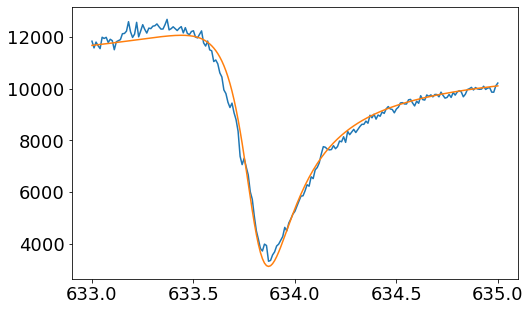

In [8]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=633.8, min=633.6, max=634),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=598.897, vary=False),
    Parameter('k_in', value=6.1, min=0, max=16),
    Parameter('k_tot', value=16.83, vary=False),
    Parameter('A', value=12000, min=5000, max=90000),
    Parameter('B', value=0, vary=False),
)

siv_avg_results = single_siv_ref_model.fit(siv_avg_data, params, w=siv_freqs, method="lbfgsb")
lmfit.report_fit(siv_avg_results)

plt.plot(siv_freqs, siv_avg_data)
plt.plot(siv_freqs, single_siv_ref_model.eval(siv_avg_results.params, w=siv_freqs))

In [9]:
# # Compute the correlations and error in the fits using MCMC
# # data_noise is a 3-tuple (expected noise in data, min estimate, max estimate)
# emcee_results, emcee_mle_params = mcmc(siv_freqs, siv_avg_data, single_siv_ref_model, siv_avg_results, 
#                                        data_noise=[500, 100, 2000], input_params={"steps": 12000})

## Fit single scan

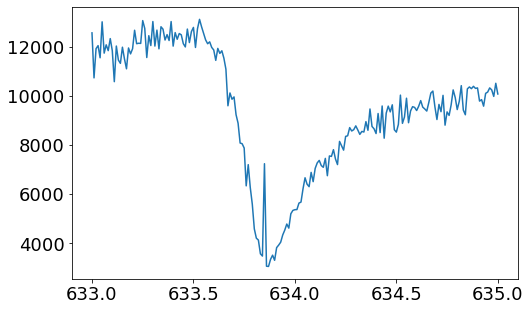

In [10]:
# Extract data from the 2nd SiV scan file (forward)
siv_data = np.loadtxt(siv_path + siv_files_tuple[1])

# Take the 7th scan
siv_fwd_7_data = siv_data[7]

plt.plot(siv_freqs, siv_fwd_7_data)

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 195
    # data points      = 201
    # variables        = 4
    chi-square         = 51128637.6
    reduced chi-square = 259536.232
    Akaike info crit   = 2509.75663
    Bayesian info crit = 2522.96985
[[Variables]]
    w_up:      633.600000 +/- 5.5334e-07 (0.00%) (init = 633.8)
    g_up:      3.04557368 +/- 0.01592838 (0.52%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       598.897 (fixed)
    k_in:      5.82474239 +/- 0.10093727 (1.73%) (init = 6.1)
    k_tot:     16.83 (fixed)
    A:         13161.8270 +/- 62.6016293 (0.48%) (init = 12000)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, A)    =  0.615
    C(g_up, k_in) = -0.241


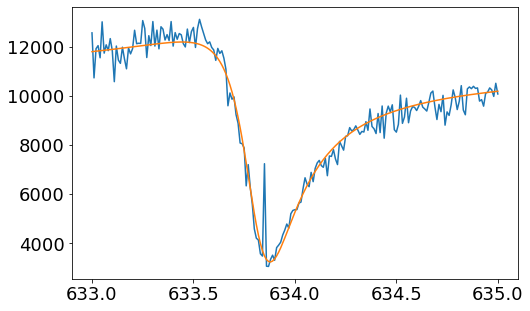

In [11]:
params = Parameters()
params.add_many(
    Parameter('w_up', value=633.8, min=633.6, max=634),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=598.897, vary=False),
    Parameter('k_in', value=6.1, min=0, max=16),
    Parameter('k_tot', value=16.83, vary=False),
    Parameter('A', value=12000, min=5000, max=90000),
    Parameter('B', value=0, vary=False),
)

siv_fwd_7_results = single_siv_ref_model.fit(siv_fwd_7_data, params, w=siv_freqs, method="lbfgsb")
lmfit.report_fit(siv_fwd_7_results)

plt.plot(siv_freqs, siv_fwd_7_data)
plt.plot(siv_freqs, single_siv_ref_model.eval(siv_fwd_7_results.params, w=siv_freqs))

In [12]:
siv_fwd_7_results

# Optimize detuning for cavity

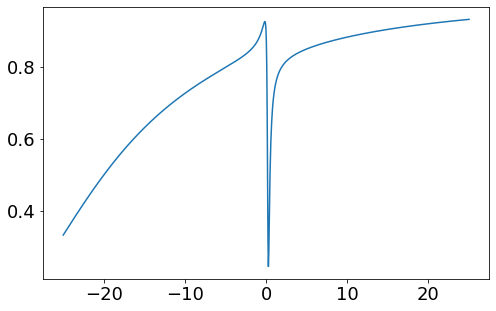

In [14]:
# Copy the fitted parameters into a Cavity object
c = Cavity({"w_c" : siv_fwd_7_results.params["w_c"].value - siv_fwd_7_results.params["w_up"].value,    
            "k_in" : siv_fwd_7_results.params["k_in"].value, 
            "k_tot" : siv_fwd_7_results.params["k_tot"].value}, 
              
           {"w_up" : 0, # Fix this to be 0, shift the cavity freq instead
            "g_up" : siv_fwd_7_results.params["g_up"].value,         
            "gamma_up" : siv_fwd_7_results.params["gamma_up"].value,  
            "g_down" : siv_fwd_7_results.params["g_up"].value,       
            "gamma_down" : siv_fwd_7_results.params["gamma_up"].value})

w_arr = np.linspace(-25, 25, 1000)
plt.plot(w_arr, c.reflectance(w_arr, 1), label="up")

Optimum contrast of 1.64 achieved at freq = 0.00519, delta = -18.2, spliting = -0.5
Maximum contrast = 1.62 located at frequency 0.025
Lower reflectivity = 0.138, higher reflectivity = 0.878
Maximum contrast = 1.64 located at frequency 0.00751
Lower reflectivity = 0.14, higher reflectivity = 0.886


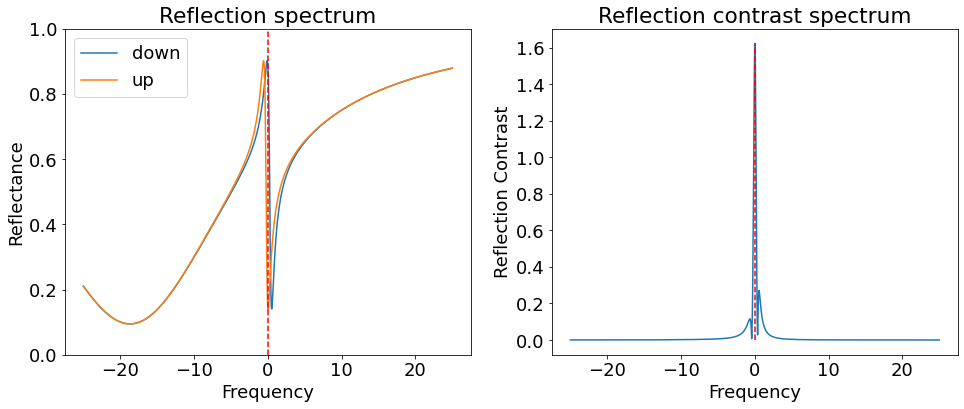

<Figure size 576x360 with 0 Axes>

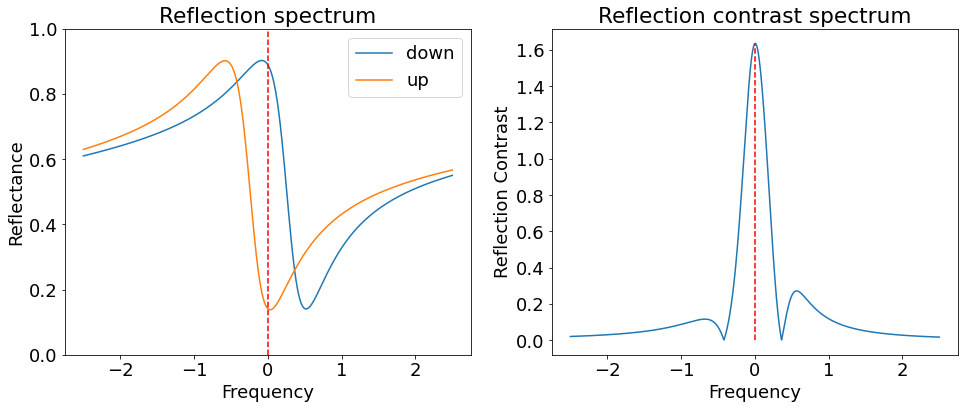

In [27]:
# Find the best detuning and splitting
(w_opt, delta_opt, splitting_opt), spin_contrast_opt = c.optimize_spin_contrast_no_SiVmodel(w_0=0, delta_0=-10, splitting_0=-0.05,
                                                                        w_bounds=(min(w_arr), max(w_arr)), 
                                                                        delta_bounds=(min(w_arr), 0), # WLOG since the cavity is symmetric
                                                                        splitting_bounds=(-0.5, 0.5)) # Based on SiV params, max B field

print("Optimum contrast of {:.3} achieved at freq = {:.3}, delta = {:.3}, spliting = {:.3}".format(spin_contrast_opt, w_opt, delta_opt, splitting_opt))

# PLot the zoomed-out spectrum
c.plot_reflection_contrast_no_SiVmodel(w_arr, delta_opt, splitting_opt)
# PLot the zoomed-in spectrum
plt.figure()
w_arr_zoom = np.linspace(-2.5, 2.5, 1000)
c.plot_reflection_contrast_no_SiVmodel(w_arr_zoom, delta_opt, splitting_opt)